In [110]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import datetime

###Step 1: Fetch Historical Stock Data

In [111]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2022, 1, 1)
tickers = ['ADBE','MSFT']

data = yf.download(tickers, start, end)['Close']
data.tail()

adbe_prices = data['ADBE']
msft_prices = data['MSFT']

[*********************100%***********************]  2 of 2 completed


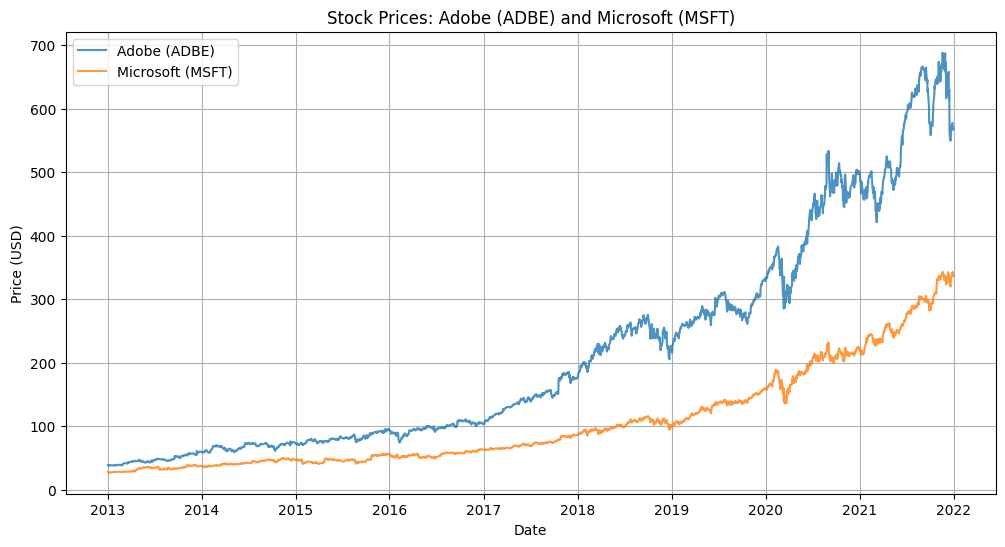

In [112]:
# Plot the prices
plt.figure(figsize=(12, 6))
plt.plot(adbe_prices, label='Adobe (ADBE)', linestyle='-', alpha=0.8)
plt.plot(msft_prices, label='Microsoft (MSFT)', linestyle='-', alpha=0.8)

plt.title('Stock Prices: Adobe (ADBE) and Microsoft (MSFT)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [113]:
data['Price_Ratio'] = adbe_prices / msft_prices

### Step 2: Feature Engineering

In [114]:
def feature_engineering(data):
    data['5d_MA'] = data['Price_Ratio'].rolling(window=5).mean()  # 5-day moving average of price ratio
    data['20d_MA'] = data['Price_Ratio'].rolling(window=20).mean()  # 20-day moving average of price ratio
    data['60d_MA'] = data['Price_Ratio'].rolling(window=60).mean()  # 60-day moving average of price ratio
    data['ROC'] = data['Price_Ratio'].pct_change(periods=5)  # Rate of change of price ratio over 5 periods
    data['5d_Volatility'] = data['Price_Ratio'].rolling(window=5).std()  # 5-day rolling volatility
    data['20d_Volatility'] = data['Price_Ratio'].rolling(window=20).std()  # 20-day rolling volatility
    data['60d_Volatility'] = data['Price_Ratio'].rolling(window=60).std()  # 60-day rolling volatility
    for lag in range(1, 6):
        data[f'Lag_{lag}'] = data['Price_Ratio'].shift(lag)  # Lag features for the past 1-5 days

    data.dropna(inplace=True)
    return data

In [115]:
data = feature_engineering(data)

In [116]:
def plot_features(data):
    features_to_plot = [
        '5d_MA', '20d_MA', '60d_MA', 'ROC',
        '5d_Volatility', '20d_Volatility', '60d_Volatility'
    ]

    for feature in features_to_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data[feature], label=feature)
        plt.title(f"{feature} Time Series")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

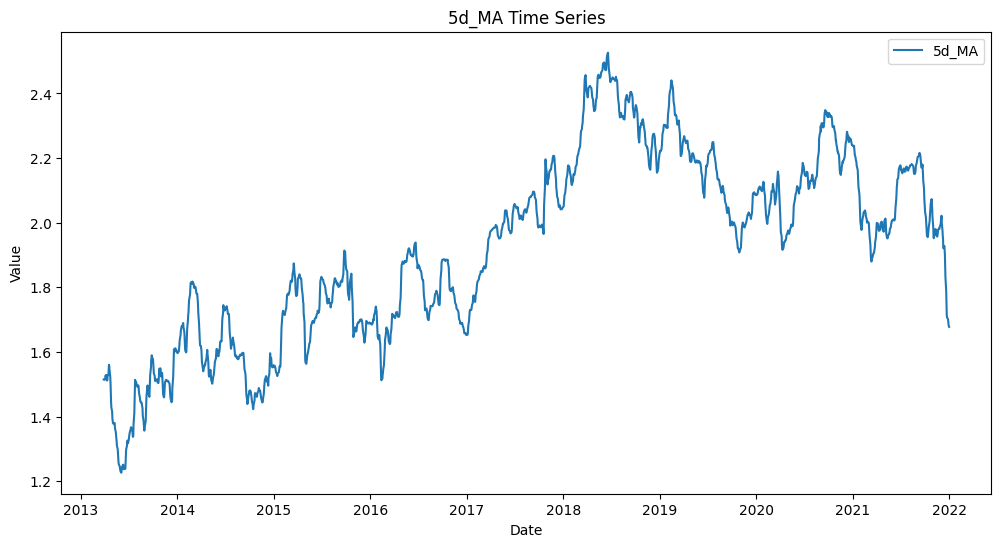

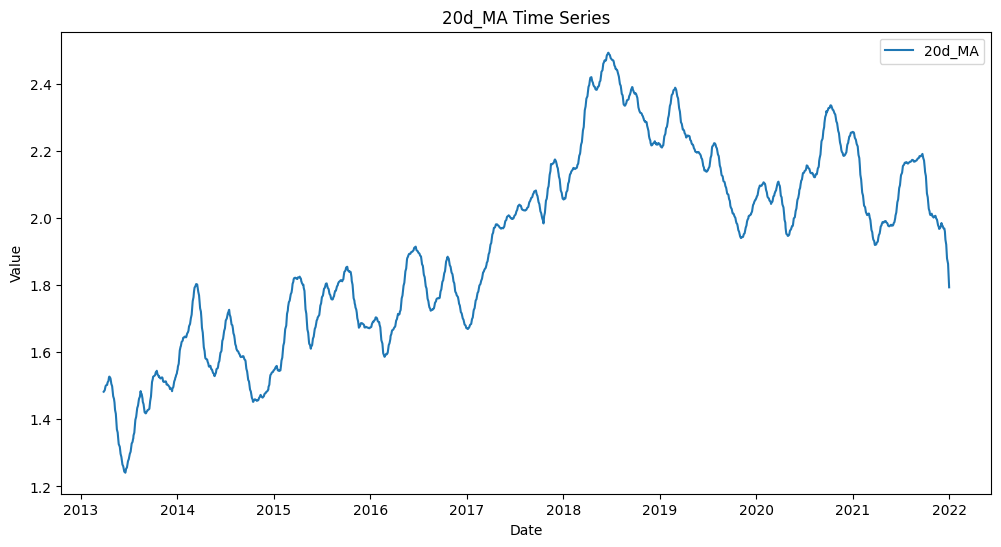

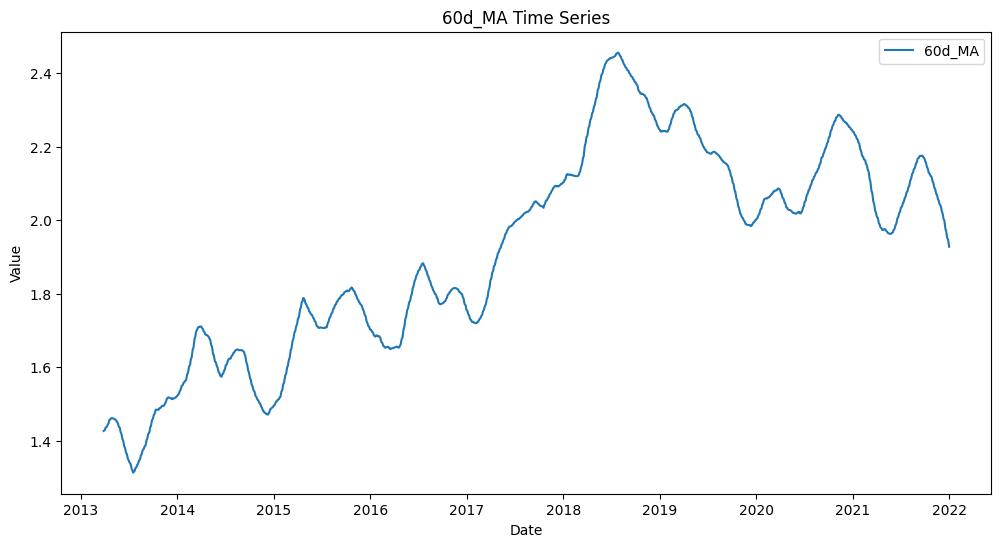

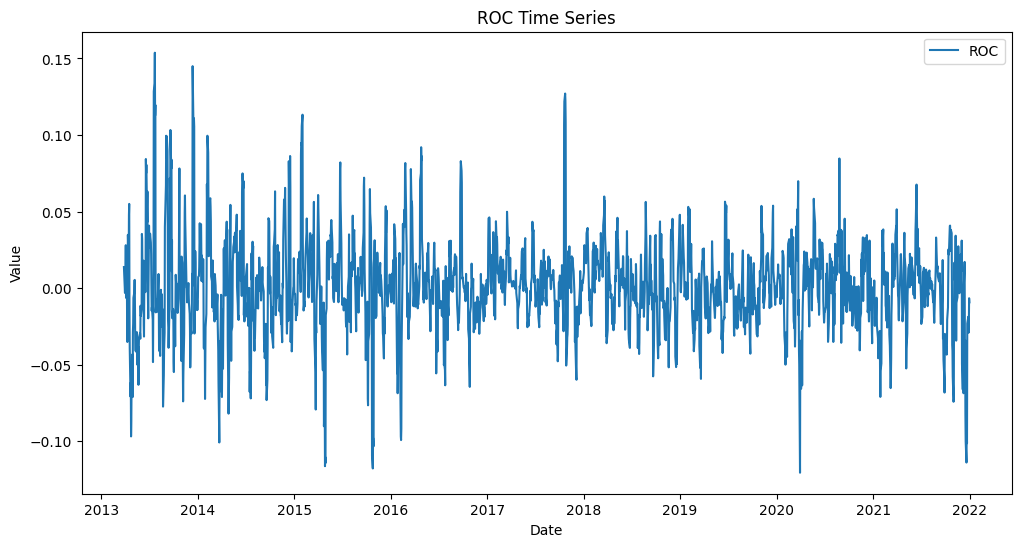

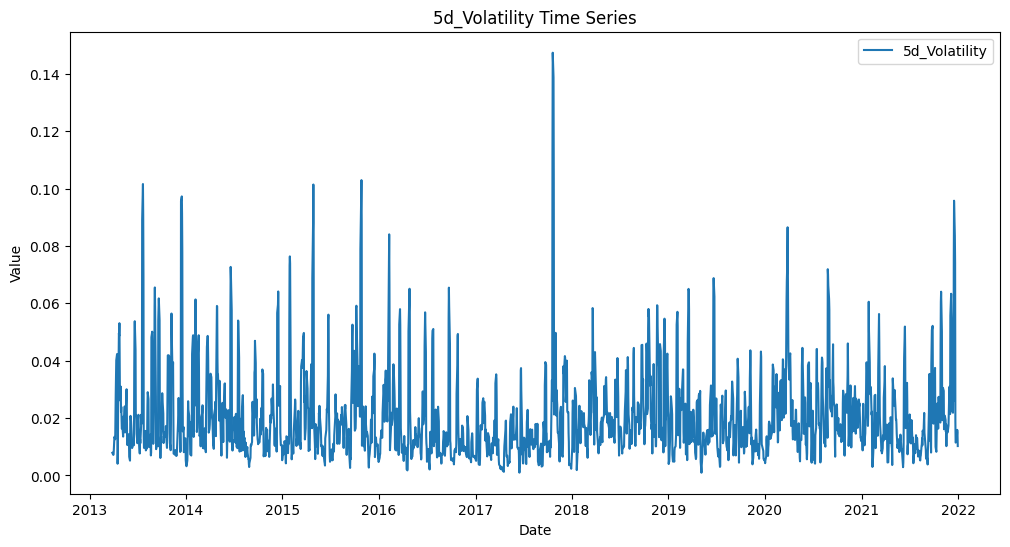

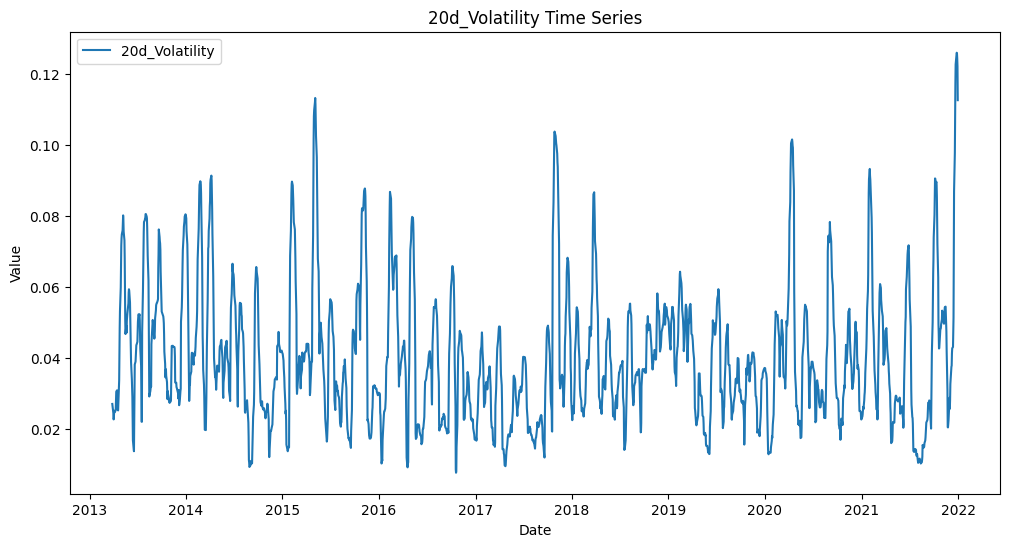

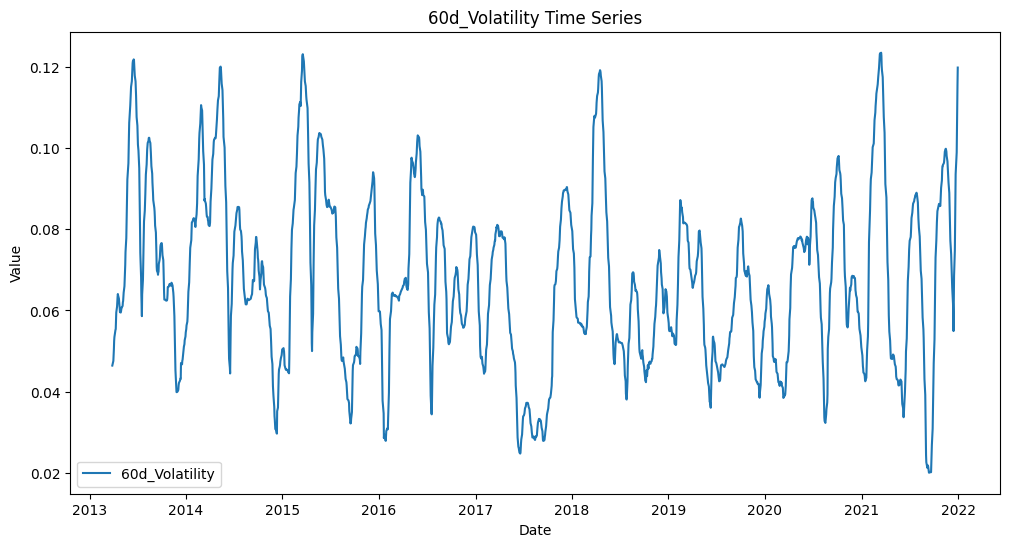

In [117]:
plot_features(data)

###Step 3: Train Machine Learning Model

In [118]:
features = ['5d_MA', '20d_MA', '60d_MA', 'ROC','5d_Volatility', '20d_Volatility', '60d_Volatility'] + [f'Lag_{i}' for i in range(1, 6)]
X = data[features]
y = data['Price_Ratio']

# Define split index
split_index = int(len(data) * 0.77)

# Split the data
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# Verify the split
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

Training set size: 1700
Test set size: 508


RandomForestRegressor(random_state=42)

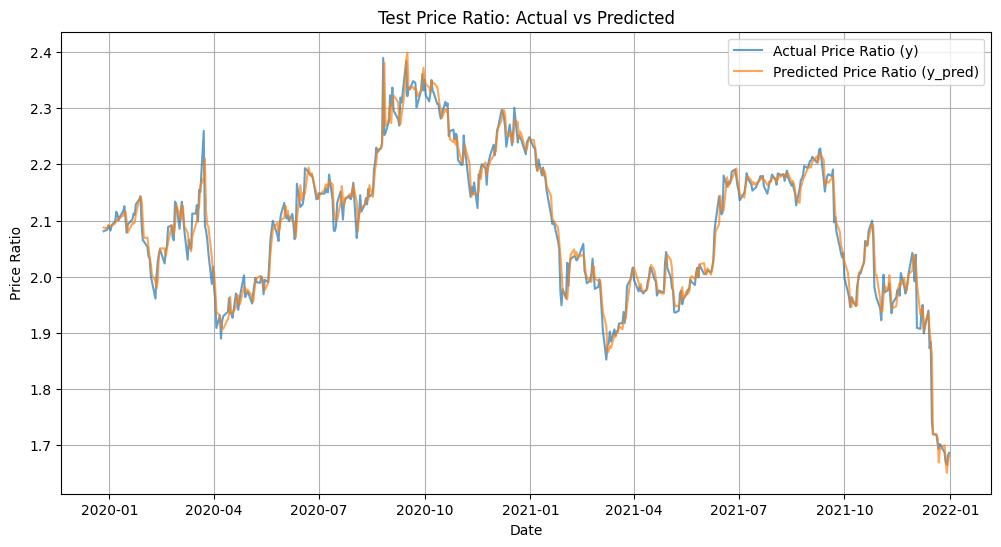

In [119]:
# Predict on the test data
y_test_pred = model.predict(X_test)

# Plot the actual and predicted values for the test dataset on the same axis
plt.figure(figsize=(12, 6))
plt.plot(y_test.index,y_test.values, label="Actual Price Ratio (y)", linestyle='-', alpha=0.7)
plt.plot(y_test.index,y_test_pred, label="Predicted Price Ratio (y_pred)", linestyle='-', alpha=0.7)

plt.title('Test Price Ratio: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.legend()
plt.grid(True)
plt.show()

### Predict on the test set (2020 - 2021)

In [120]:
predictions = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, predictions):.4f}")
data['Predicted_Ratio'] = model.predict(X)  # Predict price ratio for entire dataset

Mean Squared Error: 0.0005


### Step 4: Generate Trading Signals

In [121]:
# Define thresholds for buy/sell signals
threshold = 0.01  # Threshold for signal generation

def generate_signals(row):
    if row['Predicted_Ratio'] > row['Price_Ratio'] * (1 + threshold):
        return "Buy"  # Buy signal if predicted ratio is significantly higher
    elif row['Predicted_Ratio'] < row['Price_Ratio'] * (1 - threshold):
        return "Sell"  # Sell signal if predicted ratio is significantly lower
    else:
        return "Hold"  # Hold signal otherwise

data['Signal'] = data.apply(generate_signals, axis=1)  # Apply signal generation

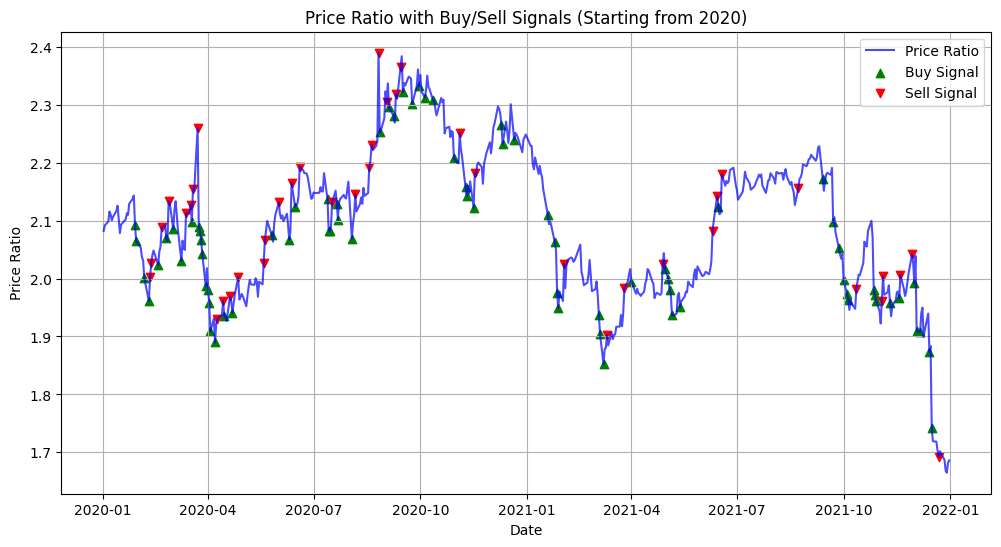

In [122]:
# Filter data starting from 2020
data_filtered = data[data.index >= '2020-01-01']

# Separate indices for buy and sell signals
buy_signals = data_filtered[data_filtered['Signal'] == 'Buy']
sell_signals = data_filtered[data_filtered['Signal'] == 'Sell']

# Plot the Price Ratio
plt.figure(figsize=(12, 6))
plt.plot(data_filtered.index, data_filtered['Price_Ratio'], label='Price Ratio', color='blue', alpha=0.7)

# Add Buy signals
plt.scatter(buy_signals.index, buy_signals['Price_Ratio'], label='Buy Signal', color='green', marker='^', alpha=1)

# Add Sell signals
plt.scatter(sell_signals.index, sell_signals['Price_Ratio'], label='Sell Signal', color='red', marker='v', alpha=1)

# Customize the plot
plt.title('Price Ratio with Buy/Sell Signals (Starting from 2020)')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.legend()
plt.grid(True)
plt.show()

### Step 5: Simulate the Trading Strategy

In [123]:
def simulate_trading(data, initial_capital=10000):
    capital = initial_capital  # Starting capital
    position_adbe = 0  # ADBE position
    position_msft = 0  # MSFT position

    pnl_list = []  # List to store PnL

    for index, row in data.iterrows():
        if row['Signal'] == "Buy":
            # Take long ADBE, short MSFT
            position_adbe += 1 / row['ADBE']
            position_msft -= 1 / row['MSFT']
        elif row['Signal'] == "Sell":
            # Take short ADBE, long MSFT
            position_adbe -= 1 / row['ADBE']
            position_msft += 1 / row['MSFT']

        # Calculate daily PnL
        pnl = (position_adbe * row['ADBE']) + (position_msft * row['MSFT'])
        pnl_list.append(pnl)

    data['PnL'] = pnl_list  # Daily PnL
    data['Cumulative_PnL'] = np.cumsum(pnl_list)  # Cumulative PnL
    return data

In [124]:
data_backtesting = simulate_trading(data_filtered)  # Simulate trading strategy

<ipython-input-123-03fa54b430c7>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PnL'] = pnl_list  # Daily PnL
<ipython-input-123-03fa54b430c7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_PnL'] = np.cumsum(pnl_list)  # Cumulative PnL


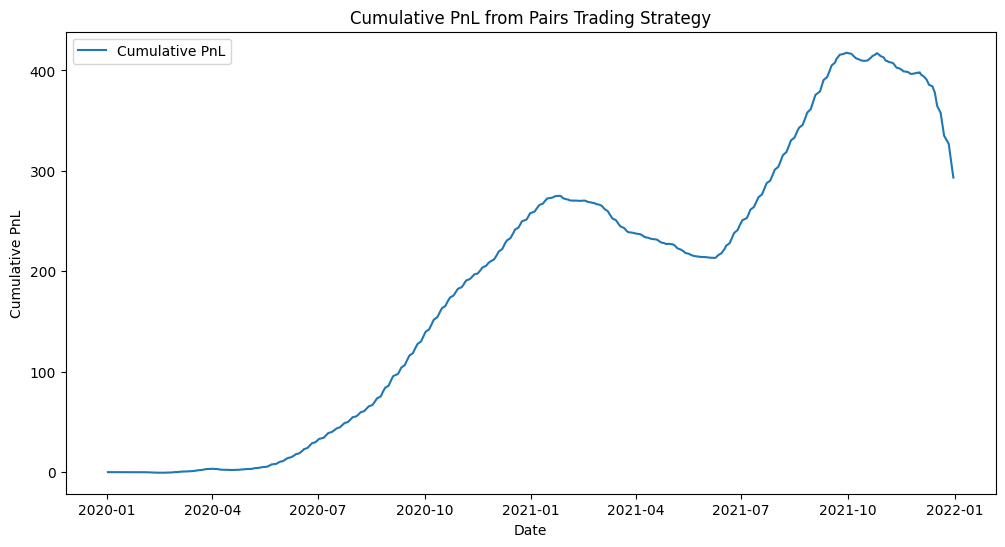

In [125]:
# Plot cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(data_backtesting.index, data_backtesting['Cumulative_PnL'], label="Cumulative PnL")
plt.title("Cumulative PnL from Pairs Trading Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()